In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import PIL
import glob
import cv2

%matplotlib inline

# Import

In [2]:
def img2array(path):
    img = PIL.Image.open(path).convert('L')
    return np.array(img)

im_array = np.array([img2array(path) for path in 
                     sorted(glob.glob('lib/leedsbutterfly/images/*'))])

mask_array = np.array([img2array(path) for path in 
                       sorted(glob.glob('lib/leedsbutterfly/segmentations/*'))])

birds_array = np.array([img2array(path) for path in 
                       sorted(glob.glob('lib/bird_images/*'))])

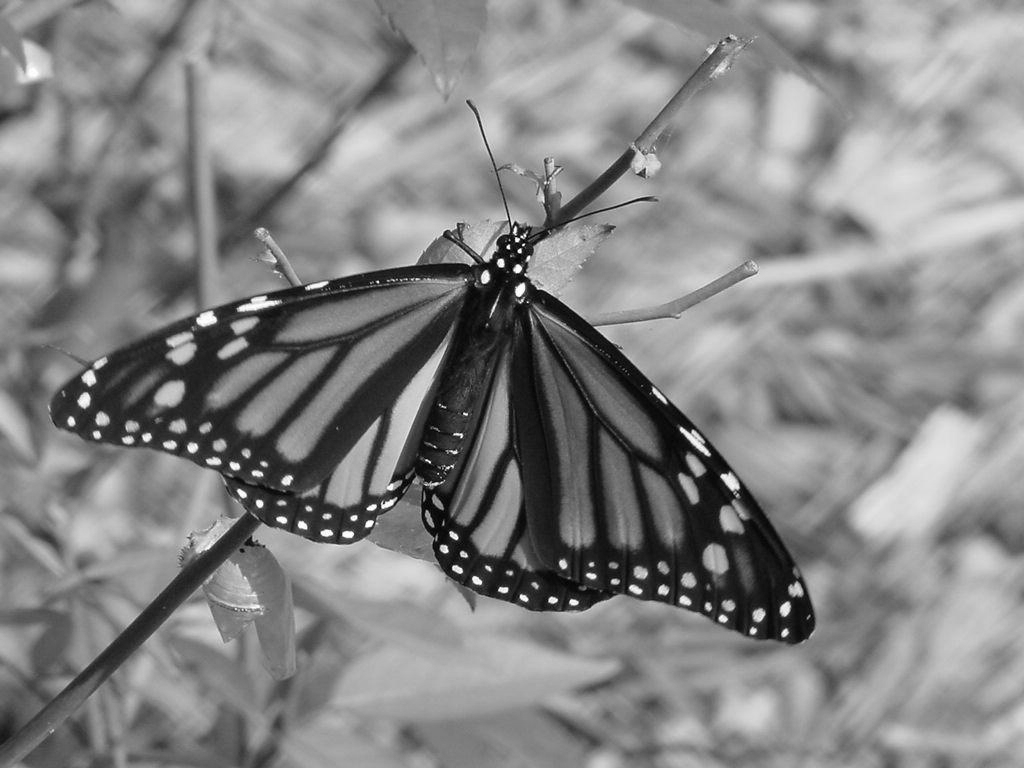

In [3]:
PIL.Image.fromarray(im_array[0])

In [4]:
im_array[0]

array([[134, 135, 137, ..., 146, 144, 144],
       [133, 134, 137, ..., 146, 145, 144],
       [131, 133, 135, ..., 146, 145, 144],
       ..., 
       [103, 105, 107, ..., 162, 161, 160],
       [105, 107, 111, ..., 159, 159, 158],
       [106, 109, 113, ..., 158, 157, 157]], dtype=uint8)

In [5]:
im_array[0].shape

(768, 1024)

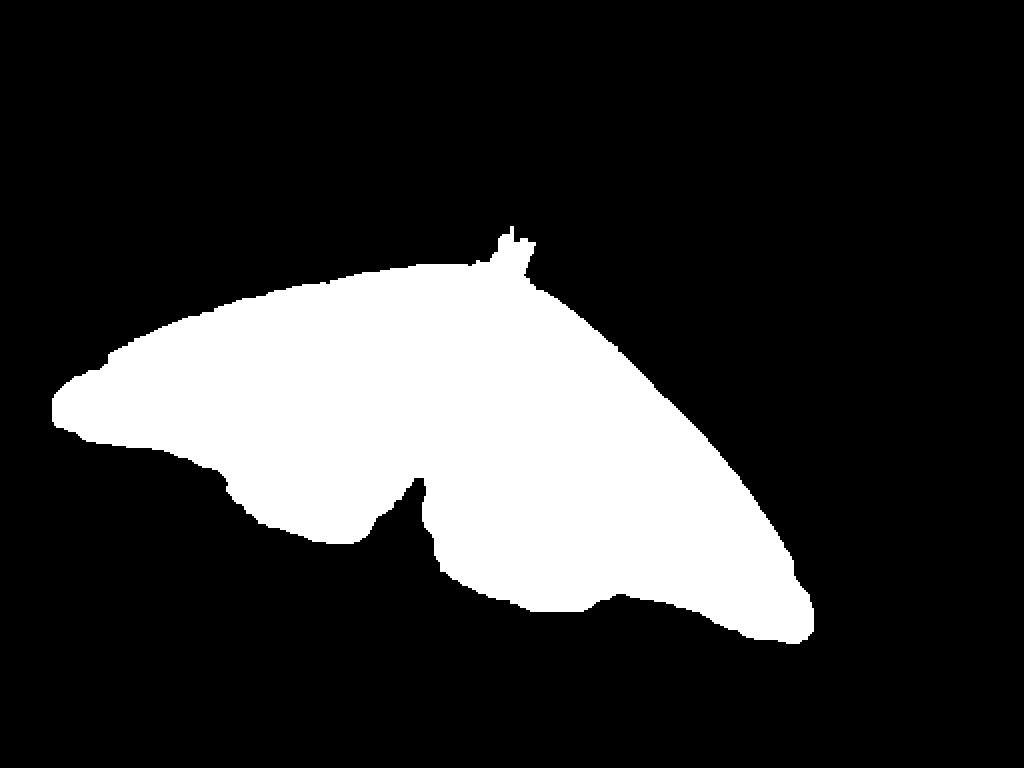

In [6]:
PIL.Image.fromarray(mask_array[0])

In [7]:
mask_array[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
mask_array[0].shape

(768, 1024)

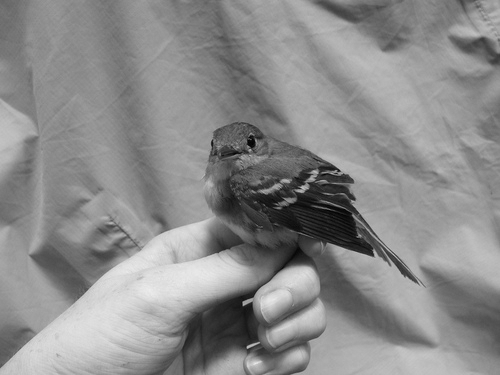

In [9]:
PIL.Image.fromarray(birds_array[0])

In [10]:
birds_array[0]

array([[103, 103, 100, ..., 160, 154, 147],
       [103, 104, 102, ..., 159, 155, 150],
       [104, 103, 103, ..., 163, 157, 152],
       ..., 
       [187, 191, 194, ..., 141, 140, 141],
       [185, 189, 191, ..., 143, 141, 140],
       [188, 192, 190, ..., 142, 141, 139]], dtype=uint8)

In [11]:
birds_array.shape

(832,)

# Filter with Mask

In [12]:
masked_im_array =  [im_array[i] * mask_array[i] for i in range(len(im_array))]

In [13]:
masked_im_array = np.array(masked_im_array)

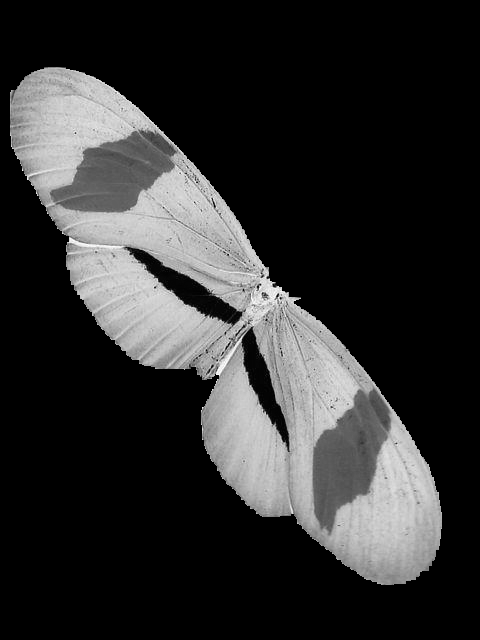

In [14]:
PIL.Image.fromarray(masked_im_array[200])

# Split into Train/Test

In [15]:
im_labels = pd.DataFrame(sorted(glob.glob('lib/leedsbutterfly/images/*')), columns=['path']).reset_index()
im_labels.head(2)

,index,path
0,0,lib/leedsbutterfly/images/001_0001.jpg
1,1,lib/leedsbutterfly/images/001_0002.jpg


In [16]:
def get_class(path):
    path = str(path)
    meta = path[-12:-4].split("_")
    return int(meta[0])

def get_position_in_class(path):
    path = str(path)
    meta = path[-12:-4].split("_")
    return int(meta[1])

im_labels['class'] = [get_class(path) for path in im_labels['path']]
im_labels['position'] = [get_position_in_class(path) for path in im_labels['path']]
im_labels.head()

,index,path,class,position
0,0,lib/leedsbutterfly/images/001_0001.jpg,1,1
1,1,lib/leedsbutterfly/images/001_0002.jpg,1,2
2,2,lib/leedsbutterfly/images/001_0003.jpg,1,3
3,3,lib/leedsbutterfly/images/001_0004.jpg,1,4
4,4,lib/leedsbutterfly/images/001_0005.jpg,1,5


In [17]:
#  isolate train/test indexes and classes
train_indexes = im_labels[im_labels.position % 2 == 1].index
train_classes = im_labels[im_labels.position % 2 == 1]['class']

test_indexes = im_labels[im_labels.position % 2 == 0].index
test_classes = im_labels[im_labels.position % 2 == 0]['class']

In [18]:
#  create train/test sets
masked_train = masked_im_array[train_indexes]
masked_test = masked_im_array[test_indexes]

im_train = im_array[train_indexes]
im_test = im_array[test_indexes]

birds_train = birds_array[:416]
birds_test = birds_array[416:]

# Demonstration of Pipeline Components: Interest Point Detection

## Harris Corner Detector

In [20]:
from matplotlib.patches import Circle

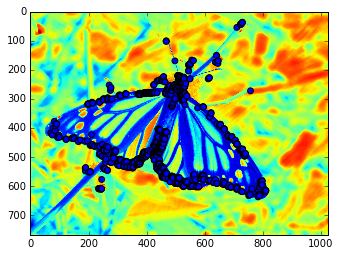

In [21]:
#  calculates harris values for all points, filters to keep only the highest few hundred, returns 
#  these coordinates
def harris_corner_points(passed_im):
    cornerMap = cv2.cornerHarris(passed_im,2,3,0.04)

    hcd_kps = []
    for x in range(0, passed_im.shape[1]):
        for y in range(0, passed_im.shape[0]):
            harris = cornerMap[y,x] # get the x,y value
            # check the corner detector response
            if harris > 1.0e-3:
                #  x, y, angle, diameter
                hcd_kps.append((x,y,0,20))
    return np.asarray(hcd_kps)

hcd_kps = harris_corner_points(im_train[0])

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(im_train[0])

# Now, loop through coord arrays, and create a circle at each x,y pair
for kp in hcd_kps:
    circ = Circle((kp[0],kp[1]),10)
    ax.add_patch(circ)

# Show the image
plt.show()

In [22]:
#  find all interest points for all images
hcd_kp_array = [harris_corner_points(img) for img in im_train]

In [23]:
len(hcd_kp_array)

418

In [24]:
#  inspect (x, y, angle, diameter)
hcd_kp_array[0][0]

array([ 70, 417,   0,  20])

## Orb

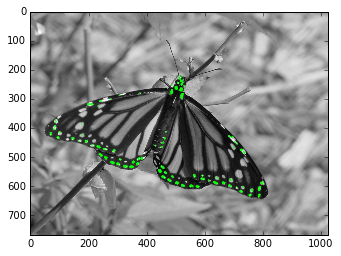

(<matplotlib.image.AxesImage at 0x7fd5c1bd34d0>, None)

In [25]:
# Initiate ORB detector
orb = cv2.ORB()

# find the keypoints with ORB
kp = orb.detect(im_train[0],None)

# compute the descriptors with ORB
kp, des = orb.compute(im_train[0], kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(im_train[0],kp,color=(0,255,0), outImage=None, flags=0)
plt.imshow(img2),plt.show()

In [26]:
print(kp[0].angle)
print(kp[0].size)
print(kp[0].pt)

93.7370605469
31.0
(453.0, 566.0)


In [27]:
#  find all interest points for all images
orb_kps = [orb.detect(img,None) for img in im_train]

In [28]:
len(orb_kps)

418

In [29]:
#  unpack all kps into x, y, angle, diameter
def unpack_kps(all_kps):
    all_kps_array = []
    for im_kps in all_kps:        
        im_kps_array = []
        for kp in im_kps:
            im_kps_array.append((kp.pt[0],kp.pt[1],kp.angle,kp.size))
        all_kps_array.append(np.asarray(im_kps_array))
    return all_kps_array

orb_kp_array = unpack_kps(orb_kps)

In [30]:
orb_kp_array[0][0]

array([ 453.        ,  566.        ,   93.73706055,   31.        ])

## Sift Interest Points

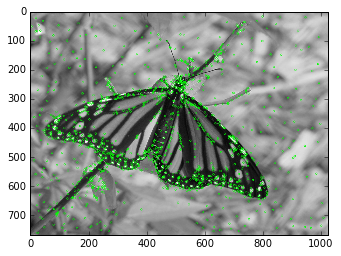

(<matplotlib.image.AxesImage at 0x7fd5c8e3ad10>, None)

In [31]:
sift = cv2.SIFT()

# find the keypoints with SIFT
kp = sift.detect(im_train[0],None)

# compute the descriptors with SIFT
kp, des = sift.compute(im_train[0], kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(im_train[0],kp,color=(0,255,0), outImage=None, flags=0)
plt.imshow(img2),plt.show()

In [32]:
#  find all interest points for all images
sift_kps = [sift.detect(img,None) for img in im_train]

In [33]:
len(sift_kps)

418

In [34]:
#  unpack all kps into x, y, angle, diameter
sift_kp_array = unpack_kps(sift_kps)

In [35]:
sift_kp_array[0][0]

array([ 707.63043213,   46.11603546,   62.21923828,    2.17988849])

# Model Definition

In [19]:
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier

import warnings
warnings.filterwarnings('ignore')

In [20]:
global_clf = None

In [80]:
class visual_classifier:
    def __init__(self):
        self.num_features = 30
    
    def fit_custom(self, pipeline_path, x_train, y_train, x_test, y_test):
        
#         import pdb
        
#         pdb.set_trace()
        
        
        #  these are arrays of KeyPoints
        self.train_kps = None
        self.test_kps = None
        
        print("Finding Interest Points")
        
        if pipeline_path[0].strip().lower() == "harris":
            self.train_kps = self.harris_corner_points(x_train)
            self.test_kps = self.harris_corner_points(x_test)
        else:
            self.train_kps = self.sift_interest_points(x_train)
            self.test_kps = self.sift_interest_points(x_test)
            
        print("Generating Description")
        
        #  these are arrays of lists o
        self.train_descs = None
        self.test_descs = None
        if pipeline_path[1].strip().lower() == "sift":
            self.train_descs = self.sift_description(x_train, self.train_kps)
            self.test_descs = self.sift_description(x_test, self.test_kps)
        else:
            self.train_descs = self.lbp_description(x_train, self.train_kps)
            self.test_descs = self.lbp_description(x_test, self.test_kps)
        
        print("Pooling")
        

        
        self.train_features = None
        self.test_features = None
        if pipeline_path[2].strip().lower() == "vector":
            self.train_features = self.vector_quantization(self.train_descs)
            self.test_features = self.vector_quantization(self.test_descs)
        else:
            self.train_features = self.spatial_pyramid_pooling(self.train_descs, x_train)
            self.test_features = self.spatial_pyramid_pooling(self.test_descs, x_test)
            
            
                
        
        print("Classifying")    
        
            
        return self.classification_accuracy(pipeline_path[3], self.train_features, y_train.as_matrix(), 
                                            self.test_features, y_test.as_matrix())
            
        
        
        
    """Model Visualization Methods"""
    def display_visual_feature_sampeles(x_train):
        
        global global_clf

    
        #  use one image, find a few keypoints from the same class
        for im_kp_descs, x_im in zip(self.train_descs, x_train):
            kps = im_kp_descs[0]  #  use this for keypoint
            descs = im_kp_descs[1]
            
            classes = []
            for i in range(len(descs)):
                classes.append(global_clf.predict(descs[0]))
        
        
            #  I need to make sure this is an ordered list of kps in the image
            #  if it is this I'll just filter by one group at a time and take the first 10 images
            #  then I'll print the first 10 instances of the class using the keypoint location
            #  and the passed image
            return sorted(list(zip(kps, classes)), lambda x: x[1]), x_im
        
            break
        
        
    def display_avg_class_histogram():
        #  summary histograms have been generated, one for each image
        sorted_im_hists = sorted(list(zip(self.train_features, y_train.as_matrix())), lambda x: x[0])
        sorted_im_hists_df = pd.DataFrame(sorted_im_hists, columns=["feature","class"])
        avg_im_hists_df = sorted_im_hists_df.groupby("class").avg()
        avg_features = avg_im_hists_df["feature"].as_matrix()
        
        #  trasform so that I can plot them
        plt.pcolor(avg_features)  #  maybe
        plt.show()
        
        
        
        
        
        
    
    """Interest point detectors"""
    def harris_corner_points(self, passed_im):
        #  find all interest points for all images
        return [self.harris_corner_points_for_instance(img) for img in passed_im]
    
    def harris_corner_points_for_instance(self, passed_im):
        cornerMap = cv2.cornerHarris(passed_im,2,3,0.04)

        hcd_kps = []
        for x in range(0, passed_im.shape[1]):
            for y in range(0, passed_im.shape[0]):
                harris = cornerMap[y,x] # get the x,y value
                # check the corner detector response
                if harris > 1.0e-3:
                    #  x, y, size, angle
                    hcd_kps.append(cv2.KeyPoint(x,y,20,0))
        return np.asarray(hcd_kps)
    
    def sift_interest_points(self, passed_im):
        self.sift = cv2.SIFT()

        # find the keypoints with SIFT
        #  find all interest points for all images
        kps = [self.sift.detect(img,None) for img in passed_im]
        return np.asarray(kps)
    
#     def unpack_kps(all_kps):
#         #  unpack all kps into x, y, angle, diameter
#         all_kps_array = []
#         for im_kps in all_kps:        
#             im_kps_array = []
#             for kp in im_kps:
#                 im_kps_array.append((kp.pt[0],kp.pt[1],kp.angle,kp.size))
#             all_kps_array.append(np.asarray(im_kps_array))
#         return all_kps_array
    
    
    """Feature Descriptors"""
    def get_single_sift_desc(self, im_kps):
        return self.sift.compute(im_kps[0], im_kps[1])
    
    def sift_description(self, im_train, kps_train):
        #  if self.sift has not already been instantiated, do so now
        try:
            self.sift
        except NameError:
            self.sift = cv2.SIFT()

        return np.asarray([self.get_single_sift_desc(im_kps) for im_kps in zip(im_train, kps_train)])

    
    def get_single_lbp_desc(self, im_kps):
        im = im_kps[0]

        im_desc_hists = []
        for kp in im_kps[1]:
            x = int(kp.pt[1])
            y = int(kp.pt[0])
            diameter = kp.size

            #  find starting positions
            start_x = x - int(diameter / 2)
            start_y = y - int(diameter / 2)
            end_x = x + int(diameter / 2) 
            end_y = y + int(diameter / 2)

            if start_x < 0: start_x = 0
            if start_y < 0: start_y = 0
            if end_x > im.shape[1]: end_x = im.shape[1]
            if end_y < im.shape[0]: end_y = im.shape[0]

            lbp_point_descs = []
            for i in range(start_x + 1, end_x - 1):
                for j in range(start_y + 1, end_y - 1):
                    # calculate the diff between surrounding pixels, then turn into number       
                    bin_diff = 0b1 if im[i,j] < im[i-1,j-1] else 0b0
                    bin_diff = (bin_diff << 1) + (0b1 if im[i,j] < im[i-1,j] else 0b0)
                    bin_diff = (bin_diff << 1) + (0b1 if im[i,j] < im[i-1,j+1] else 0b0)
                    bin_diff = (bin_diff << 1) + (0b1 if im[i,j] < im[i,j+1] else 0b0)
                    bin_diff = (bin_diff << 1) + (0b1 if im[i,j] < im[i+1,j+1] else 0b0)
                    bin_diff = (bin_diff << 1) + (0b1 if im[i,j] < im[i+1,j] else 0b0)
                    bin_diff = (bin_diff << 1) + (0b1 if im[i,j] < im[i+1,j-1] else 0b0)
                    bin_diff = (bin_diff << 1) + (0b1 if im[i,j] < im[i,j-1] else 0b0)
                    lbp_point_descs.append(bin_diff)

            im_desc_hists.append(np.bincount(np.asarray(lbp_point_descs), minlength=256))
        return np.asarray(im_desc_hists)

    def lbp_description(self, im_train, kps_train):
        #  calculate local binary pattern description for each keypoint
        return np.asarray([self.get_single_lbp_desc(im_kps) for im_kps in zip(im_train, kps_train)])

    
    
    
    """Pooling"""
    def define_features(self, im_kp_descs):
        #  first you need to create a kmeans model which will find the k features present in the computed
        #  feature descriptions
        #  used the entire dataset, just cluster all descriptions together
        all_feature_descriptions = np.vstack(im_kp_descs[:,1])
        self.kmeans_features = KMeans(n_clusters=self.num_features, n_jobs=-1).fit(all_feature_descriptions)
        
    def vector_quantization(self, im_kp_descs):
        #  for each image, go through the feature descriptions one by one, use the k-means model to
        #  place each feature in a cluster, then ++ the feature count for that feature
        #  this list is the final histogram which we'll feed into a ML model
        #  essentially we reducing the problem to one where we count to number of occurances of each type of feature
        #  and use this final histogram as the only input to a ML model
        
#         self.define_features(im_kp_descs)
        


                
        
        global global_clf
#         global_clf = self.kmeans_features
        self.kmeans_features = global_clf
        
        
        training_hists = []

        for im in im_kp_descs:
            #  kps = im[0]  #  use this for coords later
            descs = im[1]

            im_hist = np.zeros(self.num_features)
            for desc in descs:
                new_feature_num = self.kmeans_features.predict(desc)
                im_hist[new_feature_num] += 1

            training_hists.append(normalize(im_hist))
        return np.asarray(training_hists)
    
    
    def get_hist_grid_bin(self, x, y, height, width):
        x_bin = int((float(x) / float(width)) * 4.0)
        y_bin = int((float(y) / float(height)) * 4.0)
        return (4 * y_bin) + x_bin

    def spatial_pyramid_pooling(self, all_im_kp_descs, all_x_im_train):
        #  for each image, go through the feature descriptions and their coords one by one, use the k-means model to
        #  place each feature in a cluster at it's location, then ++ the feature count for that feature at the coord
        #  once concatenated all together this list is the final histogram which we'll feed into a ML model
        #  essentially we reducing the problem to one where we count to number of occurances of each type of feature
        #  and use this final histogram as the only input to a ML model
        
#         self.define_features(all_im_kp_descs)
        
        
        
        
                
        
        global global_clf
#         global_clf = self.kmeans_features
        self.kmeans_features = global_clf
        
        
        
        
        training_hists = []

        for im_kp_descs, x_im in zip(all_im_kp_descs, all_x_im_train):
            kps = im_kp_descs[0]  #  use this for keypoint
            descs = im_kp_descs[1]
            height = x_im.shape[1]
            width = x_im.shape[0]

            #  grid layout
            #   0, 1, 2, 3
            #   4, 5, 6, 7
            #   8, 9,10,11
            #  12,13,14,15

            im_hist_level_2 = np.zeros((16, self.num_features))
            im_hist_level_1 = np.zeros((4, self.num_features))
            im_hist_level_0 = np.zeros(self.num_features)


            for kp, desc in zip(kps, descs):
                new_feature_num = self.kmeans_features.predict(desc)
                #  ++ the found feature count of the correct coordinate bin in the level 2 grid
                im_hist_level_2[self.get_hist_grid_bin(kp.pt[1], kp.pt[0], height, width)]\
                                    [new_feature_num] += 1

            im_hist_level_1[0] = im_hist_level_2[0] + im_hist_level_2[1] + im_hist_level_2[4] + im_hist_level_2[5]
            im_hist_level_1[1] = im_hist_level_2[2] + im_hist_level_2[3] + im_hist_level_2[6] + im_hist_level_2[7]
            im_hist_level_1[2] = im_hist_level_2[8] + im_hist_level_2[9] + im_hist_level_2[12] + im_hist_level_2[13]
            im_hist_level_1[3] = im_hist_level_2[10] + im_hist_level_2[11] + im_hist_level_2[14] + im_hist_level_2[15]
            im_hist_level_0 = im_hist_level_1.sum(axis=0)   


            #  add flatened weighted layers together then normalize
            im_hist_combined = np.concatenate((im_hist_level_0.flatten() * 0.25, im_hist_level_1.flatten() * 0.25))
            im_hist_combined = np.concatenate((im_hist_combined, im_hist_level_2.flatten() * 0.5))
            training_hists.append(normalize(im_hist_combined))

        return np.asarray(training_hists)
    
    
    
    """This is exactly the same as vector quant, the only difference is we have a grid system that we find
    a seperate vq histogram for. The lowest level 2 has 16 cells, then level 1 has 4 cells (combine lower
    cells to get their value) then level 0 is all of them summed together into one histogram. It was
    confusing in the paper but it's just what I thought. The only thing you need to do after this is
    just concat the histograms all together back to back. The level is weighted different, roughly micmicing
    a guassian or something like that. """
    
    
    """Classification"""
    def generate_prec_rec_curve(self, y_true, y_pred_prob):
        precisions = []
        recalls = []

        for threshold in np.arange(0,1, 0.001):
            y_thresholded_pred = (y_pred_prob > threshold) * 1.0
            tp = tn = fp = fn = 0

            for i in range(len(y_true)):
                if y_true[i] == 0:
                    if y_thresholded_pred[i] == 0:
                        tn += 1
                    else:
                        fp += 1
                else:
                    if y_thresholded_pred[i] == 1:
                        tp += 1
                    else:
                        fn += 1

            if tp + fp == 0:
                break
    #             precisions.append(0.0)
            else:
                precisions.append(tp / float(tp + fp))
            if tp + fn == 0:
                break
    #             recalls.append(0.0)
            else:
                recalls.append(tp / float(tp + fn))

        return precisions, recalls

    def display_all_class_pr_curves(self, test_y_ohe, score_y):
        for i in range(test_y_ohe.shape[1]):
            pr_curve = self.generate_prec_rec_curve(test_y_ohe[:, i], score_y[:, i])
            plt.plot(pr_curve[1], pr_curve[0])
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.ylim(0, 1.1)
    
    def one_hot_encoding(self, passed_y, n_classes):
        final_labels = []

        for y in passed_y:
            encoded_array = np.zeros(n_classes)
            encoded_array[y - 1] = 1
            final_labels.append(encoded_array)

        return np.asarray(final_labels)
    
    
    def display_confusion_matrix(self, test_y, pred_y):
        cm = np.zeros((10,10))
        for i in range(len(test_y)):
            cm[test_y[i] - 1][pred_y[i] - 1] += 1

        #  normalize
        for i in range(len(cm)):
            if cm[i].sum() > 0:
                cm[i] = cm[i] / cm[i].sum()
    
        self.cm = cm
        print ("Confusion Matrix")
        print (cm)
    
    
    def classification_accuracy(self, classifier_str, train_x, train_y, test_x, test_y):
        #  reduce to proper dimensions for classifier
        train_x = train_x.squeeze()
        train_y = train_y.squeeze()
        test_x = test_x.squeeze()
        test_y = test_y.squeeze()
        test_y_ohe = self.one_hot_encoding(test_y, 10)
        
        
        if classifier_str.strip().lower() == "random forest":
            self.rf_clf = RandomForestClassifier(n_estimators=10000)
            self.rf_clf.fit(train_x, train_y)
            
            score_y = self.rf_clf.predict_proba(test_x)
            self.display_all_class_pr_curves(test_y_ohe, score_y)
            
            pred_y = self.rf_clf.predict(test_x)
            self.display_confusion_matrix(test_y, pred_y)
            
            return self.rf_clf.score(test_x, test_y)
        else:
            self.lsvc_clf = OneVsRestClassifier(LinearSVC())
            self.lsvc_clf.fit(train_x, train_y)
            
            score_y = self.lsvc_clf.decision_function(test_x)
            self.display_all_class_pr_curves(test_y_ohe, score_y)
            
            pred_y = self.rf_clf.predict(test_x)
            self.display_confusion_matrix(test_y, pred_y)
            
            return self.lsvc_clf.score(test_x, test_y)

#  Best Model Visualization

### Set up the model, then display it's results with external methods

Finding Interest Points
Generating Description
Pooling
Classifying


IndexError: index 10 is out of bounds for axis 0 with size 10

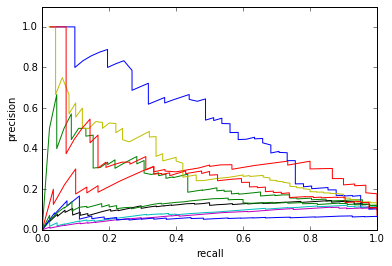

In [26]:
#  Sift key points, Sift descriptions,  Vector Quant, Random Forest Classifier
c = visual_classifier()
clf.fit_custom(["sift","sift","spatial","random forest"], masked_train, train_classes,
                 masked_test, test_classes)

Finding Interest Points
Generating Description
Pooling
Classifying


IndexError: index 10 is out of bounds for axis 0 with size 10

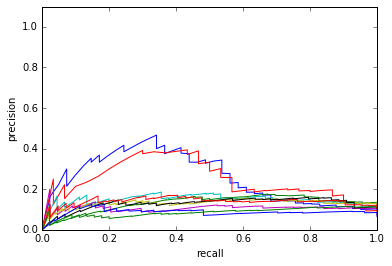

In [24]:
#  Sift key points, Sift descriptions,  Vector Quant, Random Forest Classifier
clf = visual_classifier()
clf.fit_custom(["sift","sift","vector","random forest"], masked_train, train_classes,
                 masked_test, test_classes)

## Confusion Matrix

In [76]:
def display_confusion_matrix(test_y, pred_y):
    cm = np.zeros((10,10))
    
#     import pdb
#     pdb.set_trace()
    
    for i in range(len(test_y)):
        cm[test_y[i] - 1][pred_y[i] - 1] += 1

    #  normalize
    for i in range(len(cm)):
        if cm[i].sum() > 0:
            cm[i] = cm[i] / cm[i].sum()

    cm = cm
    print ("Confusion Matrix")
    print (cm)
    return cm
    

In [73]:
def classification_accuracy(classifier_str, train_x, train_y, test_x, test_y):
        #  reduce to proper dimensions for classifier
        train_x = train_x.squeeze()
        train_y = train_y.squeeze()
        test_x = test_x.squeeze()
        test_y = test_y.squeeze()
        
        print("1")
        
        if classifier_str.strip().lower() == "random forest":
            rf_clf = RandomForestClassifier(n_estimators=10000)
            rf_clf.fit(train_x, train_y)
                
            print("2")    
                
            pred_y = rf_clf.predict(test_x)
#             display_confusion_matrix(test_y, pred_y)
            
            return test_y, pred_y
        else:
            lsvc_clf = LinearSVC()
            lsvc_clf.fit(train_x, train_y)
            return lsvc_clf.score(test_x, test_y)

In [66]:
tru_y, pred_y = classification_accuracy("random forest", clf.train_features, train_classes.as_matrix(), 
                        clf.test_features, test_classes.as_matrix())

1
2


In [77]:
cm = display_confusion_matrix(tru_y, pred_y)

Confusion Matrix
[[ 0.34146341  0.          0.          0.53658537  0.07317073  0.          0.
   0.          0.          0.04878049]
 [ 0.          0.15217391  0.02173913  0.19565217  0.04347826  0.
   0.10869565  0.17391304  0.17391304  0.13043478]
 [ 0.          0.1         0.06666667  0.26666667  0.03333333  0.
   0.03333333  0.46666667  0.03333333  0.        ]
 [ 0.08888889  0.02222222  0.          0.11111111  0.          0.
   0.44444444  0.          0.06666667  0.26666667]
 [ 0.06818182  0.          0.          0.43181818  0.          0.02272727
   0.31818182  0.02272727  0.          0.13636364]
 [ 0.          0.08        0.          0.38        0.18        0.16        0.02
   0.02        0.04        0.12      ]
 [ 0.          0.02272727  0.          0.54545455  0.25        0.02272727
   0.09090909  0.          0.02272727  0.04545455]
 [ 0.33333333  0.07407407  0.18518519  0.03703704  0.          0.07407407
   0.2962963   0.          0.          0.        ]
 [ 0.          0.0888

In [79]:
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,0.341463,0.000000,0.000000,0.536585,0.073171,0.000000,0.000000,0.000000,0.000000,0.048780
1,0.000000,0.152174,0.021739,0.195652,0.043478,0.000000,0.108696,0.173913,0.173913,0.130435
2,0.000000,0.100000,0.066667,0.266667,0.033333,0.000000,0.033333,0.466667,0.033333,0.000000
3,0.088889,0.022222,0.000000,0.111111,0.000000,0.000000,0.444444,0.000000,0.066667,0.266667
4,0.068182,0.000000,0.000000,0.431818,0.000000,0.022727,0.318182,0.022727,0.000000,0.136364
5,0.000000,0.080000,0.000000,0.380000,0.180000,0.160000,0.020000,0.020000,0.040000,0.120000
6,0.000000,0.022727,0.000000,0.545455,0.250000,0.022727,0.090909,0.000000,0.022727,0.045455
7,0.333333,0.074074,0.185185,0.037037,0.000000,0.074074,0.296296,0.000000,0.000000,0.000000
8,0.000000,0.088889,0.000000,0.511111,0.266667,0.000000,0.000000,0.022222,0.066667,0.044444
9,0.000000,0.000000,0.000000,0.404762,0.095238,0.095238,0.071429,0.000000,0.000000,0.333333


# Visual Words

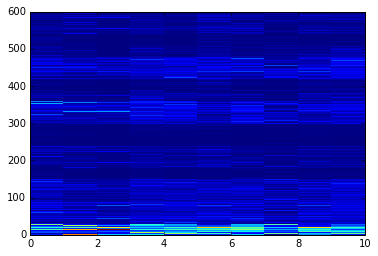

In [30]:
def display_avg_class_histogram(train_features, y_train):
    #  summary histograms have been generated, one for each image
    sorted_im_hists = list(zip(train_features, y_train))
    sorted_im_hists_df = pd.DataFrame(sorted_im_hists, columns=["feature","class"])
    
    def avg_array(x_array):
        #   TODO: This might need to be an array
#         import pdb
#         pdb.set_trace()
        return [np.asarray(list(x_array)).squeeze().mean(axis=0)]
    avg_im_hists_df = sorted_im_hists_df.groupby("class").agg([avg_array])
    avg_features = avg_im_hists_df["feature"].as_matrix()

    avg_features = np.asarray(list(np.asarray(list(avg_features)).squeeze())).squeeze()
    
    #  trasform so that I can plot them
    plt.pcolor(avg_features.T)  #  maybe
    plt.ylim(0,600)
    
display_avg_class_histogram(clf.train_features, train_classes.as_matrix())

Display


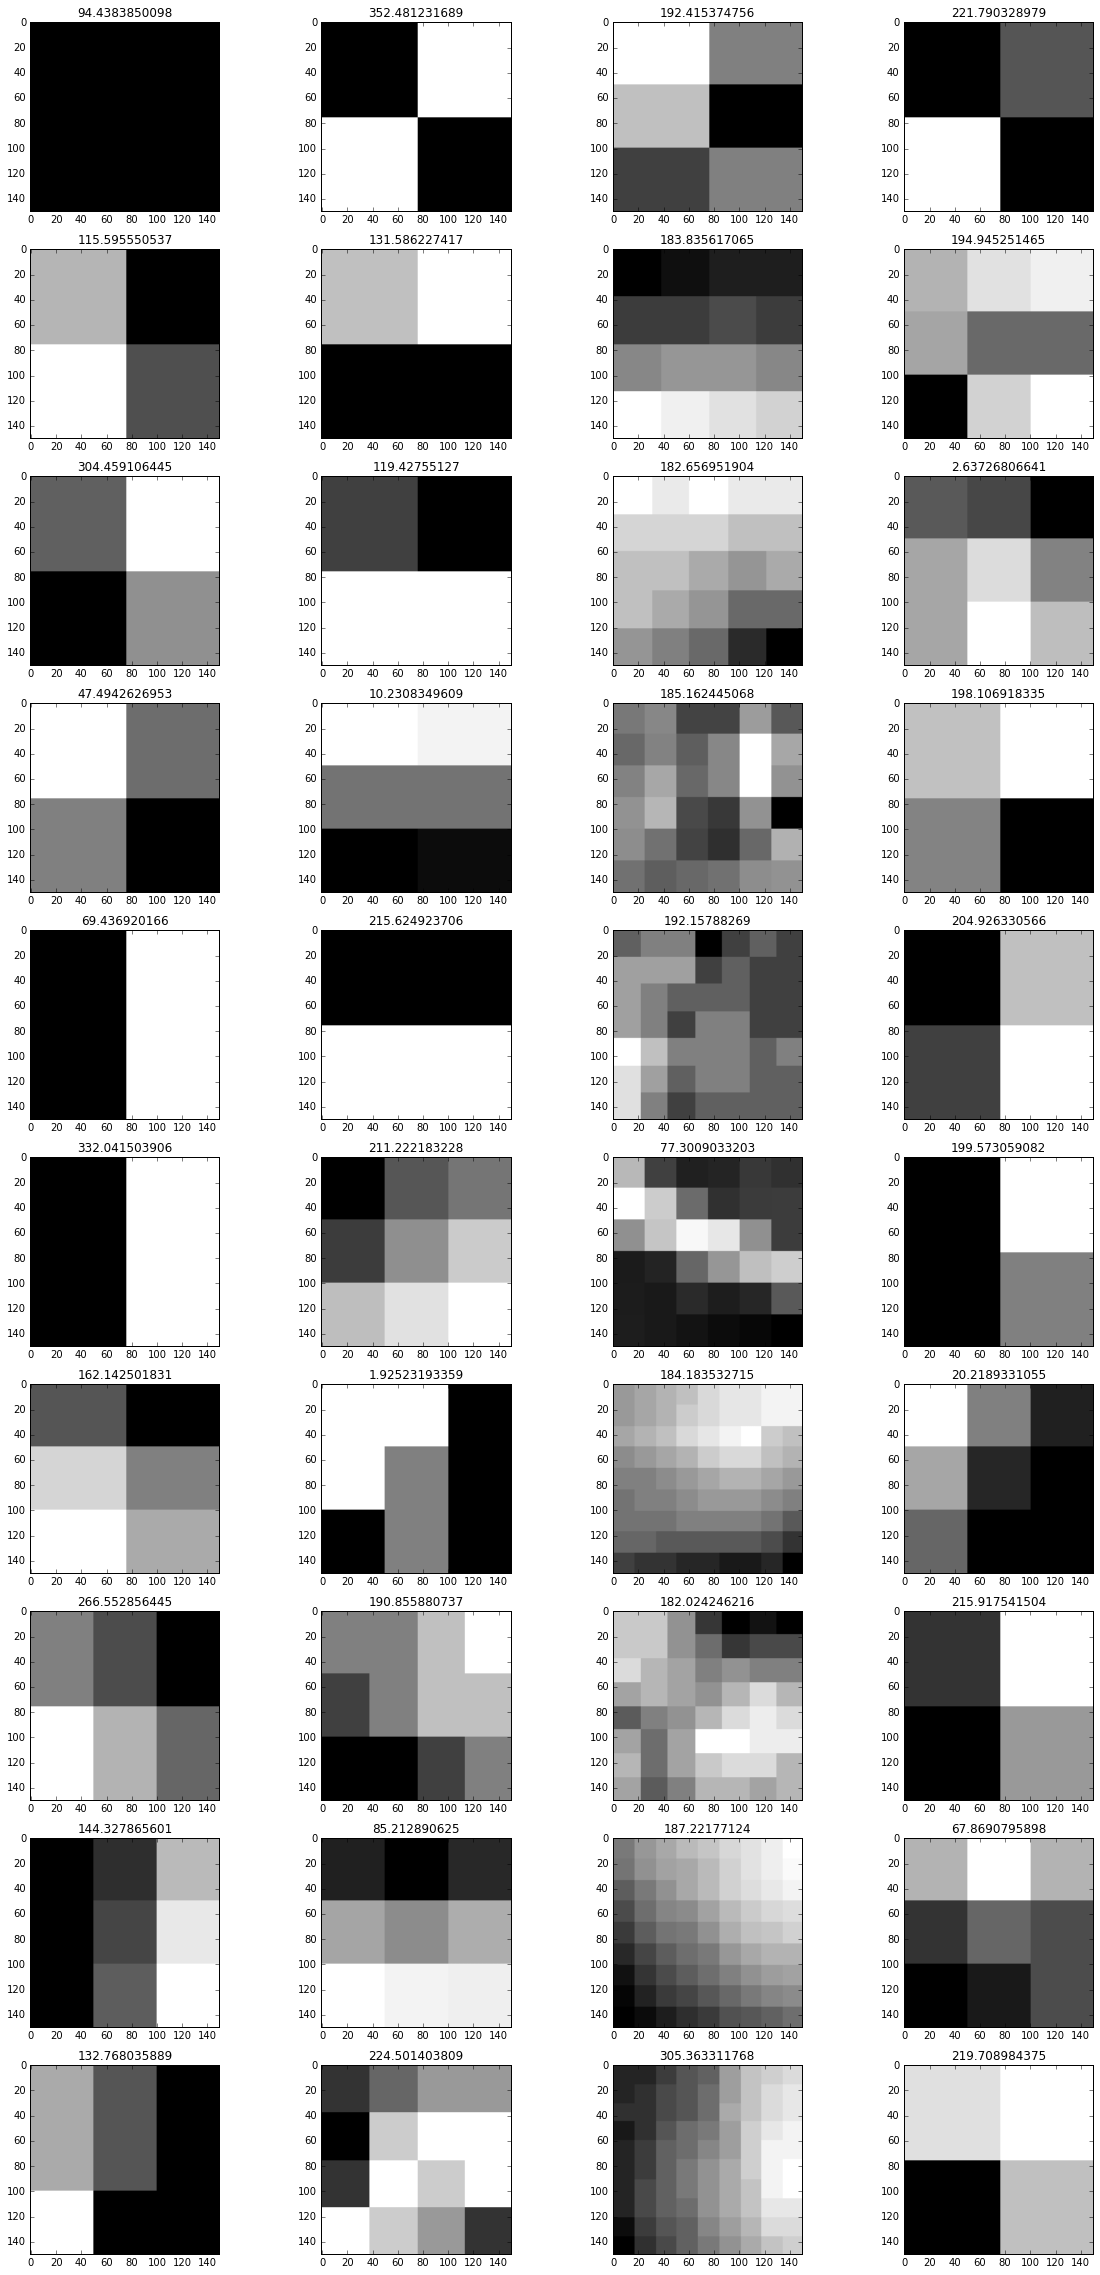

In [79]:
"""Model Visualization Methods"""
from PIL import Image


# def get_source_im_keypoint(kp, x_im):
#     return subimage(cv.fromarray(x_im), kp.pt, kp.angle, int(kp.size), int(kp.size))


def get_source_im_keypoint(kp, x_im):
    #  need to include 
    y_upper_left = kp.pt[0] - int(kp.size / 2)
    x_upper_left = kp.pt[1] - int(kp.size / 2)

    if y_upper_left < 0:
        y_upper_left = 0
    if x_upper_left < 0:
        x_upper_left = 0
        
    return x_im[y_upper_left:y_upper_left + kp.size, x_upper_left:x_upper_left + kp.size]
#     return x_im[y_upper_left:y_upper_left + (kp.size * 2), x_upper_left:x_upper_left + (kp.size * 2)]



def get_closest_num_of_90_deg_rotations(deg):
    if deg < 45.0:
        return 0
    elif deg < 135:
        return 1
    elif deg < 225:
        return 2
    elif deg < 315:
        return 3
    else:
        return 0


def rotate_to_closest_90_degs(im_array, deg):
    num_of_90_deg_rotations = get_closest_num_of_90_deg_rotations(deg)
    for i in range(num_of_90_deg_rotations):
        im_array = np.rot90(im_array)
    return im_array



def display_visual_feature_sampeles(train_descs, x_train):
#     train_descs = train_descs.squeeze()
    global global_clf
    

    
    for (im_kp_descs, x_im) in zip(train_descs, x_train):
        kps = im_kp_descs[0]
        descs = im_kp_descs[1]
        
        classes = []
        for i in range(len(descs)):
            classes.append(int(global_clf.predict(descs[i])))


        #  I need to make sure this is an ordered list of kps in the image
        #  if it is this I'll just filter by one group at a time and take the first 10 images
        #  then I'll print the first 10 instances of the class using the keypoint location
        #  and the passed image
        
#         import pdb
#         pdb.set_trace()
        
    
        
        kp_classes = pd.DataFrame({"kps":kps, "classes":classes})
        class_1_kps = kp_classes[kp_classes.classes == 10].loc[:,"kps"][:10]
        class_2_kps = kp_classes[kp_classes.classes == 11].loc[:,"kps"][:10]
        class_3_kps = kp_classes[kp_classes.classes == 19].loc[:,"kps"][:10]
        class_4_kps = kp_classes[kp_classes.classes == 20].loc[:,"kps"][:10]
        class_kps = [class_1_kps, class_2_kps, class_3_kps, class_4_kps]

#         return class_kps
        print("Display")

        fig, axes = plt.subplots(10, 4, figsize=(20,40))
        for i in range(4):
            for j in range(10):
                ax_i = (j * 4) + i
                kp_j = class_kps[i].iloc[j]
                kp_j_angle = kp_j.angle
                kp_im = get_source_im_keypoint(kp_j, x_im)
                kp_im = rotate_to_closest_90_degs(kp_im, kp_j_angle)
#                 kp_im = np.asarray(kp_im[:,:])
                kp_im = Image.fromarray(kp_im).resize((150, 150))
#                 kp_im = Image.fromarray(kp_im)
#                 return kp_im, kp_j, x_im
                axes[j,i].imshow(kp_im, cmap="gray")
                axes[j,i].set_title(str(kp_j_angle))
        #  TODO: after checking return filter this correctly

        break
        
display_visual_feature_sampeles(clf.train_descs, im_train)  